In [1]:
import urllib.request, json 
import pandas as pd

# 5min BTC/USDT chart form Poloniex since 2017-01-01T00:00:00+00:00 till 2018-10-14T20:00:00+00:00
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1483228800&end=1539547200&period=300") as url:
    data_USDT_BTC = json.loads(url.read().decode())
print("USDT_BTC downloaded")
    
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_ETH = json.loads(url.read().decode())
print("BTC_ETH downloaded")

with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_XRP = json.loads(url.read().decode())
print("BTC_XRP downloaded")

with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_LTC = json.loads(url.read().decode())
print("BTC_LTC downloaded")

with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XMR&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_XMR = json.loads(url.read().decode())
print("BTC_XMR downloaded")

with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_DASH = json.loads(url.read().decode())
print("BTC_DASH downloaded")

print(data_USDT_BTC[0])

df = pd.DataFrame(data=data_USDT_BTC, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['BTC_ETH'] = pd.DataFrame(data=data_BTC_ETH, columns=['weightedAverage']).iloc[:, 0]
df['BTC_XRP'] = pd.DataFrame(data=data_BTC_XRP, columns=['weightedAverage']).iloc[:, 0]
df['BTC_LTC'] = pd.DataFrame(data=data_BTC_LTC, columns=['weightedAverage']).iloc[:, 0]
df['BTC_XMR'] = pd.DataFrame(data=data_BTC_XMR, columns=['weightedAverage']).iloc[:, 0]
df['BTC_DASH'] = pd.DataFrame(data=data_BTC_DASH, columns=['weightedAverage']).iloc[:, 0]
df.head()

df = df.fillna(method='ffill')
df. to_csv("poloniex_usdt_btc_20170101_many_coins_300.csv", sep=";", index=False)

USDT_BTC downloaded
BTC_ETH downloaded
BTC_XRP downloaded
BTC_LTC downloaded
BTC_XMR downloaded
BTC_DASH downloaded
{'date': 1483228800, 'high': 965.00000066, 'low': 964.00000002, 'open': 965.00000055, 'close': 964.00000127, 'volume': 5398.83711674, 'quoteVolume': 5.59672254, 'weightedAverage': 964.64262399}


In [2]:
import csv
import numpy as np
import pandas as pd

df = pd.read_csv("poloniex_usdt_btc_20170101_many_coins_300.csv", sep=";", index_col=None)

df.head()

,date,open,high,low,close,volume,BTC_ETH,BTC_XRP,BTC_LTC,BTC_XMR,BTC_DASH
0,1483228800,965.000001,965.000001,964.000000,964.000001,5398.837117,0.008357,0.000007,0.004499,0.014309,0.011764
1,1483229100,966.150000,966.150000,964.000002,964.000002,84.302118,0.008399,0.000007,0.004487,0.014311,0.011764
2,1483229400,964.050000,966.149988,962.028165,964.000000,2638.676171,0.008428,0.000007,0.004487,0.014362,0.011764
3,1483229700,962.028165,964.000000,961.700000,962.200001,3415.272309,0.008490,0.000007,0.004500,0.014367,0.011764
4,1483230000,964.000011,964.677377,962.769304,962.849999,80.287691,0.008516,0.000007,0.004525,0.014369,0.011738


In [3]:
print("Shape of whole dataset: ", df.shape)

Shape of whole dataset:  (187729, 11)


In [4]:
# Turn dataframe into a numpy floating point array
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1:].astype("float")

In [5]:
# Split the dataset into training (80%), cross validation (10%) and test (10%) set
samples_num = dataset.shape[0]

valid_split = 0.1
test_split = 0.1

dataset_train = dataset[0:int(samples_num * (1-valid_split-test_split))]
dataset_valid = dataset[int(samples_num * (1-valid_split-test_split)):int(samples_num * (1-test_split))]
dataset_test = dataset[int(samples_num * (1-test_split)):samples_num]

print(dataset_train.shape)
print(dataset_valid.shape)
print(dataset_test.shape)

(150183, 10)
(18773, 10)
(18773, 10)


In [6]:
# Makes a training examples from year data with a timesteps window size

def makeXy(data, timesteps):
    X = []
    y = []
    
    for i in range(timesteps, data.shape[0]-2):
        X.append(list(data[i-timesteps:i]))
        
        y.append(sum(data[i:i+2])/2)
        
    X, y = np.array(X), np.array(y)
    return X, y

In [7]:
import numpy as np

# Create training examples
timestep = 250

train_X, train_y = makeXy(dataset_train, timestep)
valid_X, valid_y = makeXy(dataset_valid, timestep)
test_X, test_y = makeXy(dataset_test, timestep)
    
print(train_X.shape)
print(train_y.shape)

(149931, 250, 10)
(149931, 10)


In [8]:
train_y = np.expand_dims(train_y, axis=1)
valid_y = np.expand_dims(valid_y, axis=1)
test_y = np.expand_dims(test_y, axis=1)

print(train_X.shape)
print(train_y.shape)

(149931, 250, 10)
(149931, 1, 10)


In [9]:
from sklearn.preprocessing import MinMaxScaler

for i in range(train_X.shape[0]):
    scaler = MinMaxScaler().fit(np.array(train_X[i]))
    train_X[i] = scaler.transform(train_X[i])
    train_y[i] = scaler.transform(train_y[i])
    
for i in range(valid_X.shape[0]):
    scaler = MinMaxScaler().fit(np.array(valid_X[i]))
    valid_X[i] = scaler.transform(valid_X[i])
    valid_y[i] = scaler.transform(valid_y[i])
    
for i in range(test_X.shape[0]):
    scaler = MinMaxScaler().fit(np.array(test_X[i]))
    test_X[i] = scaler.transform(test_X[i])
    test_y[i] = scaler.transform(test_y[i])


In [10]:
print(train_X.shape)
print(train_y.shape)

print(train_X[0])
print(train_y[0])

(149931, 250, 10)
(149931, 1, 10)
[[0.14750805 0.10251079 0.15392894 ... 0.25448281 0.93515236 0.68693481]
 [0.17225628 0.12735103 0.15392899 ... 0.15793595 0.93648998 0.68692418]
 [0.12706383 0.12735077 0.11044434 ... 0.15715292 0.9920395  0.68692418]
 ...
 [0.9516237  1.         1.         ... 0.         0.18434217 0.20987195]
 [1.         0.95817215 0.95589429 ... 0.10664787 0.30786045 0.19524999]
 [0.94375594 0.96651966 0.99188408 ... 0.0617806  0.25846619 0.19977685]]
[[ 1.00831658  0.97731977  1.01399041  1.00895228  0.09638272  0.03986495
  -0.00877193  0.15625245  0.26452357  0.06902928]]


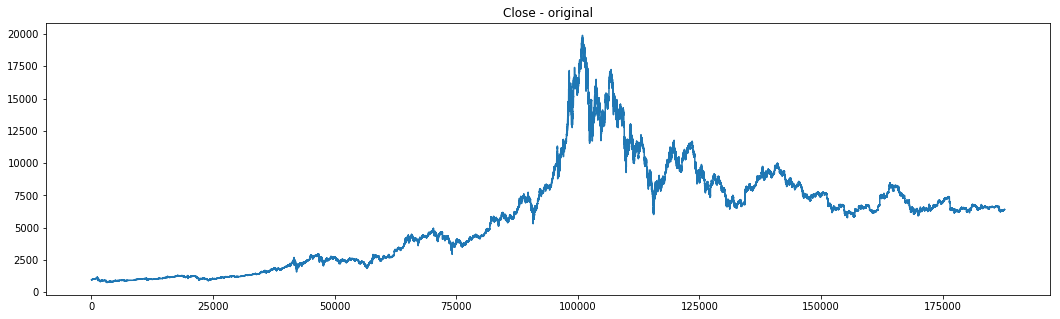

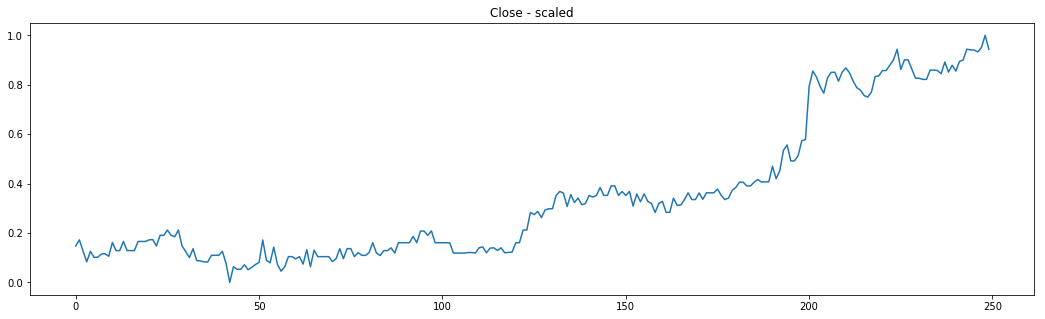

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 5))
plt.title('Close - original')
plt.plot(dataset[:,0])
plt.show()

plt.figure(figsize=(18, 5))
plt.title('Close - scaled')
plt.plot(train_X[0,:,0])
plt.show()

In [12]:
import tensorflow as tf
from keras import backend as K

num_cores = 6

num_CPU = 1
num_GPU = 1

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.callbacks import Callback
from keras.optimizers import Adam, Adadelta
from keras.layers import Dropout, Conv1D, Flatten, MaxPooling1D, LSTM, BatchNormalization, Input, Lambda, TimeDistributed, CuDNNLSTM
from keras import regularizers
from tensorflow import set_random_seed
from keras.utils.generic_utils import get_custom_objects

# Set random seed to always predict the same values
np.random.seed(1)
set_random_seed(2) # Tensoflow

Using TensorFlow backend.


In [13]:
# Saving loss and acc values

class TrainingHistory(Callback):

    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.epoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.epoch += 1
            
history = TrainingHistory()

In [14]:
# train_X = np.expand_dims(train_X, axis=2)
print(train_X.shape)
print(train_y.shape)

train_y = train_y.reshape(-1,train_X.shape[2])
valid_y = valid_y.reshape(-1,train_X.shape[2])
test_y = test_y.reshape(-1,train_X.shape[2])

print(train_y[0].shape)

(149931, 250, 10)
(149931, 1, 10)
(10,)


In [15]:
# Create model
model = Sequential()

model.add(CuDNNLSTM(128, return_sequences=True, input_shape = train_X[0].shape))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(CuDNNLSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(train_y[0].shape[0]))
model.compile(loss='mean_squared_error', optimizer= Adam())

model.save('model.h5')


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 250, 128)          71680     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 250, 128)          16512     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 238,090
Trainable params: 238,090
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Setting up early stopping and weight saving on actually best solutions

from keras.callbacks import EarlyStopping
patience=5
early_stopping=EarlyStopping(patience=patience, verbose=1)

from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

In [18]:
# Training model

model.fit(train_X, train_y,
          batch_size=1024,
          epochs=100,
          validation_data=(valid_X,valid_y), 
          callbacks=[checkpointer, early_stopping, history],
          shuffle= True)

Train on 149931 samples, validate on 18521 samples
Epoch 1/100
149931/149931 [==============================] - 31s 206us/step - loss: 0.0280 - val_loss: 0.0134

Epoch 00001: val_loss improved from inf to 0.01341, saving model to weights.hdf5
Epoch 2/100
149931/149931 [==============================] - 29s 196us/step - loss: 0.0074 - val_loss: 0.0106

Epoch 00002: val_loss improved from 0.01341 to 0.01060, saving model to weights.hdf5
Epoch 3/100
149931/149931 [==============================] - 30s 197us/step - loss: 0.0059 - val_loss: 0.0098

Epoch 00003: val_loss improved from 0.01060 to 0.00977, saving model to weights.hdf5
Epoch 4/100
149931/149931 [==============================] - 30s 197us/step - loss: 0.0053 - val_loss: 0.0092

Epoch 00004: val_loss improved from 0.00977 to 0.00919, saving model to weights.hdf5
Epoch 5/100
149931/149931 [==============================] - 30s 199us/step - loss: 0.0050 - val_loss: 0.0090

Epoch 00005: val_loss improved from 0.00919 to 0.00900, sa

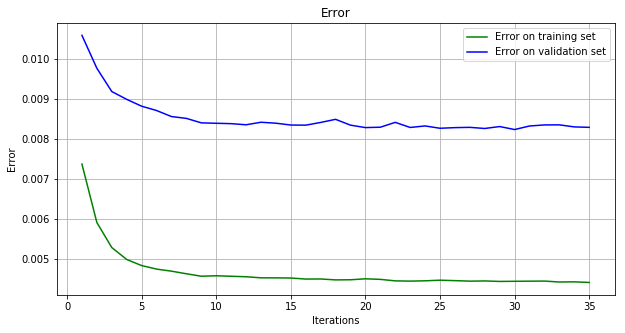

In [19]:
# Plot training history

from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.title('Error')
plt.plot(np.arange(history.epoch)[1:], history.losses[1:], color ='g', label='Error on training set') 
plt.plot(np.arange(history.epoch)[1:], history.valid_losses[1:], color ='b', label='Error on validation set')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [20]:
# Calculate predictions for test set

import sys
from keras.models import load_model
from sklearn.externals import joblib

# Load best saved model
model.load_weights("weights.hdf5")

pred_data, _ = makeXy(dataset_test, timestep)

# Make prediction for next 25 timesteps
prediction_range = 25
prediction_lookback = timestep

predictions = np.zeros(pred_data[0].shape)       
scalers = []
to_predict = []
        
for i in range(0, (pred_data.shape[0]-prediction_range)//prediction_range * prediction_range, prediction_range):    
    r = pred_data[i]
    scaler = MinMaxScaler().fit(r)
    r = scaler.transform(r)

    scalers.append(scaler)
    to_predict.append(r)
    
to_predict = np.array(to_predict)

for candles in range(prediction_range):
    d = to_predict[:, -prediction_lookback:] 
    next = model.predict(d)
    next = np.expand_dims(next, axis=1)
    to_predict = np.append(to_predict, next, axis=1) # Add prediction to known candles

print(to_predict.shape)

for i in range(to_predict.shape[0]):
    inverse_scaled = scalers[i].inverse_transform(to_predict[i, -prediction_range:, :])
    predictions = np.append(predictions, inverse_scaled, axis=0)

(739, 275, 10)


In [21]:
print(predictions.shape)

test_close = pred_data[prediction_lookback:,0, 0]
pred_close = predictions[prediction_lookback:, 0]

print(test_close.shape)
print(pred_close.shape)

(18725, 10)
(18271,)
(18475,)


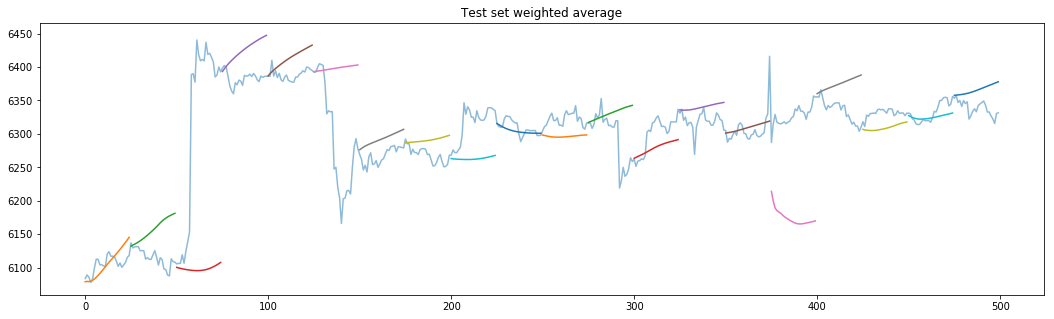

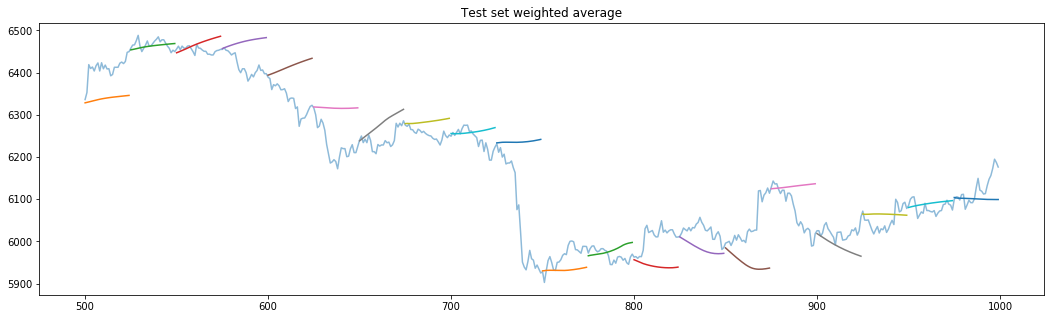

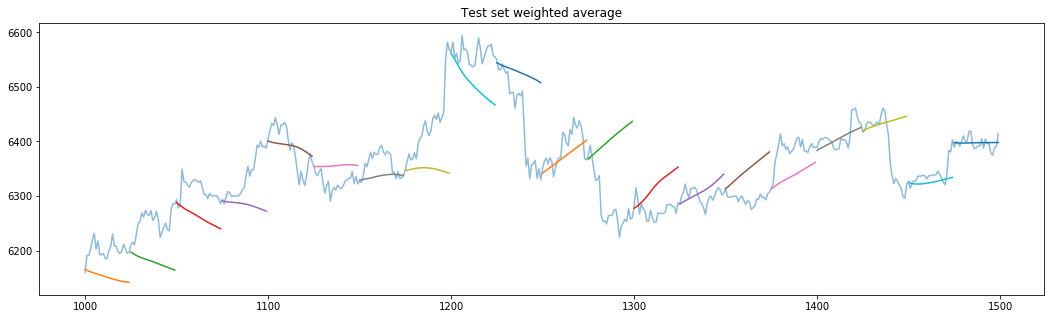

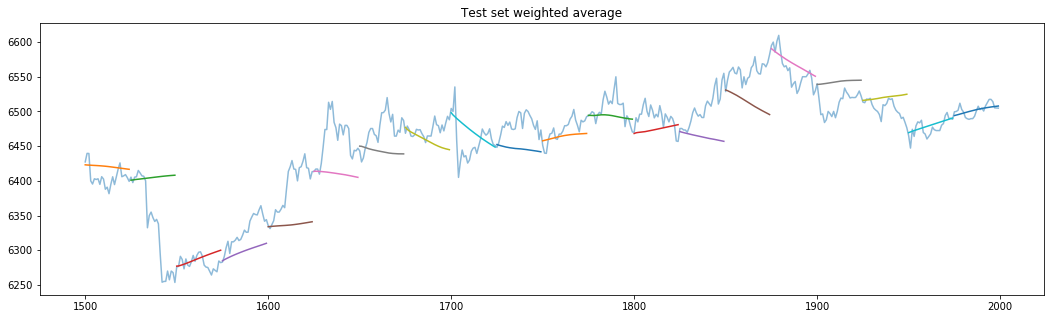

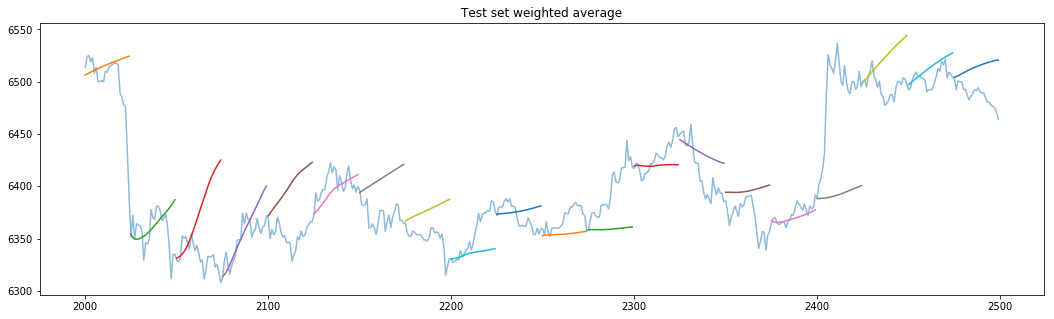

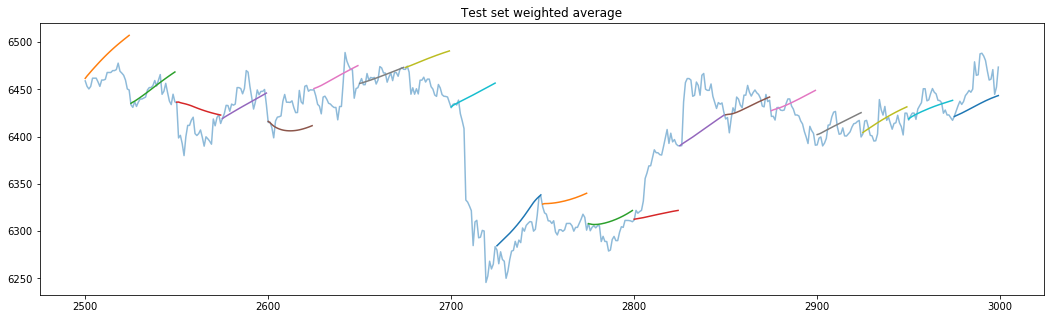

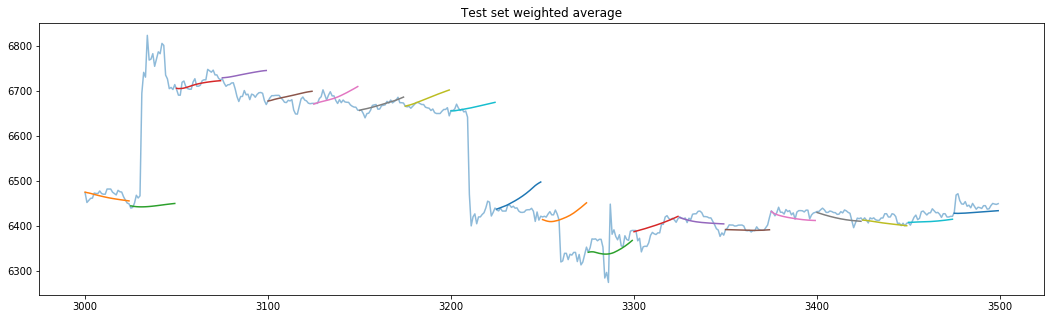

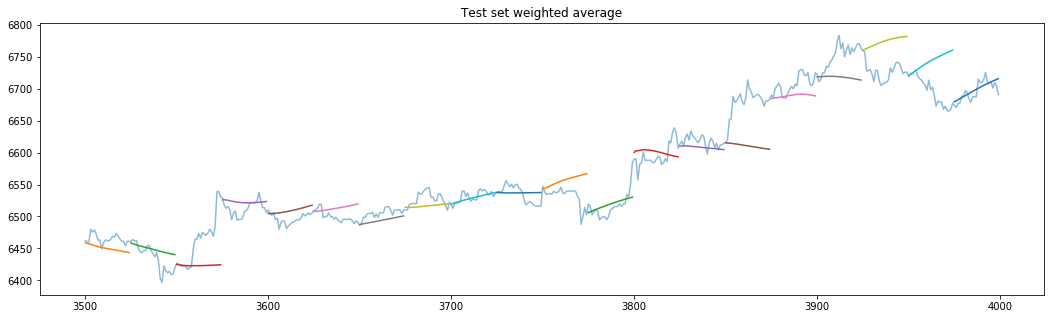

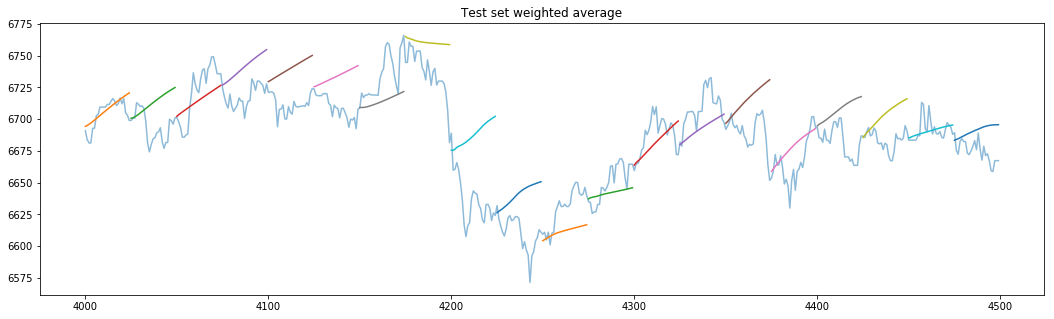

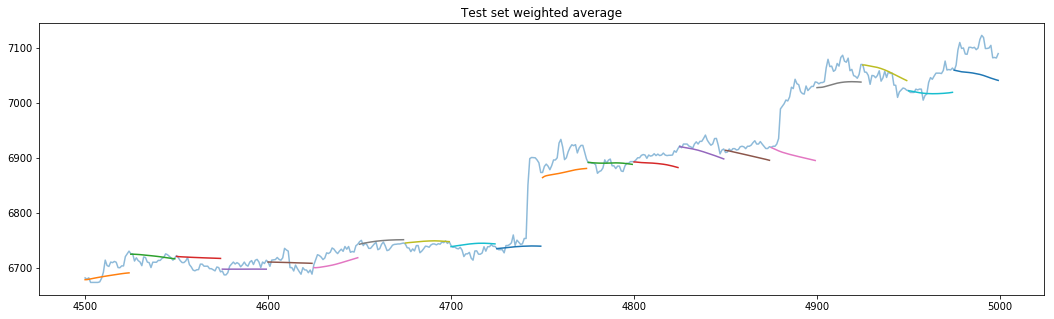

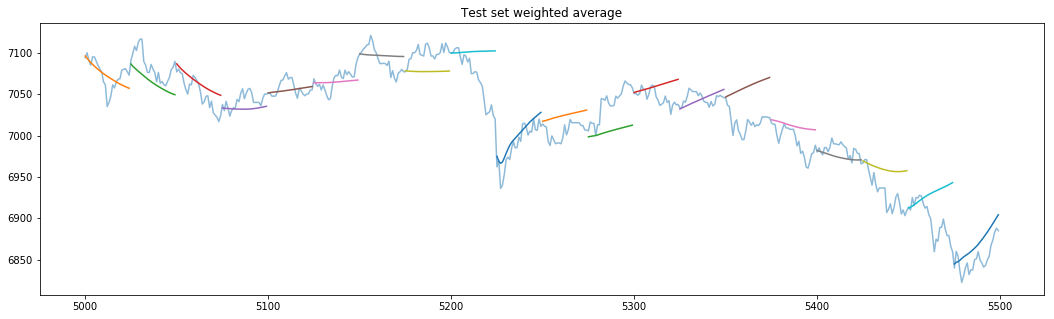

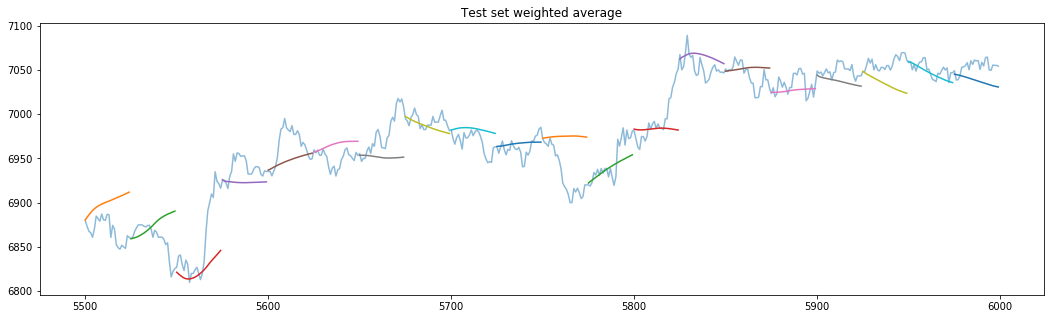

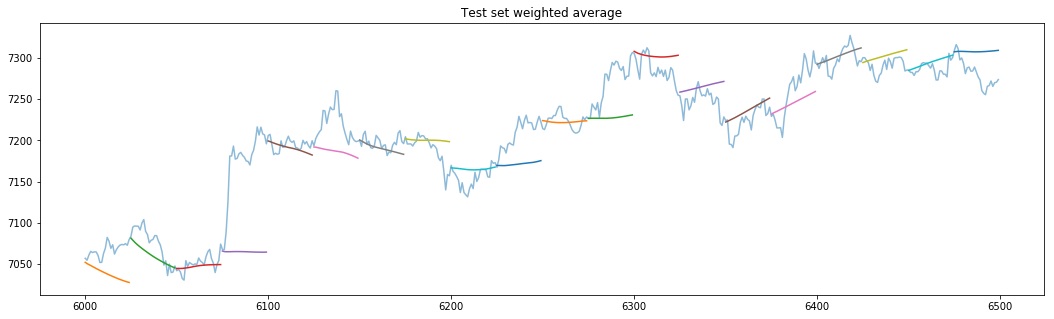

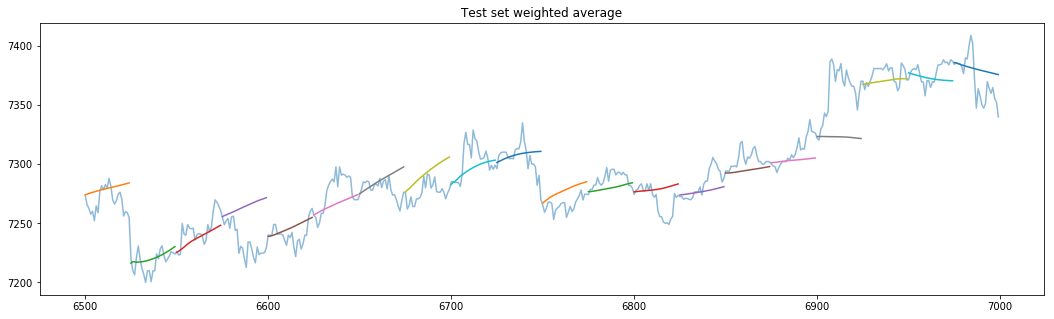

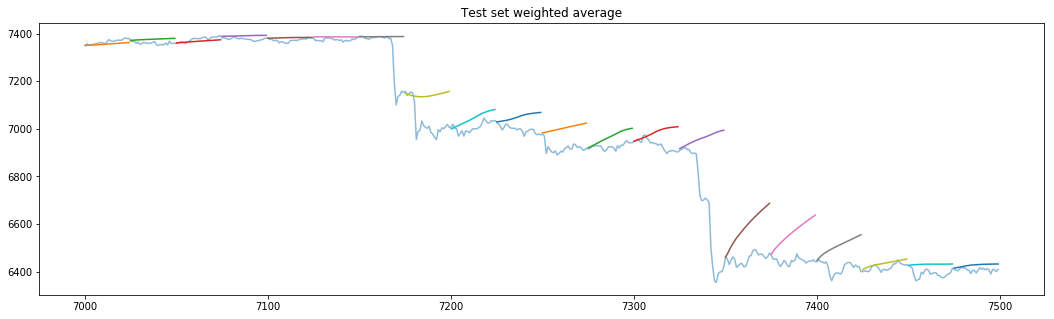

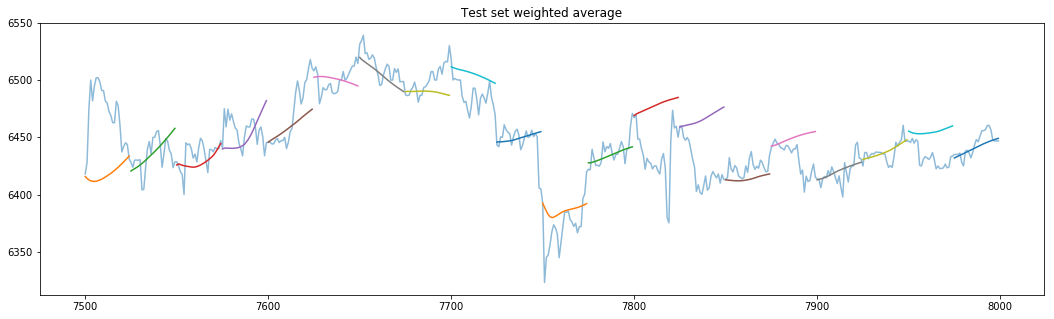

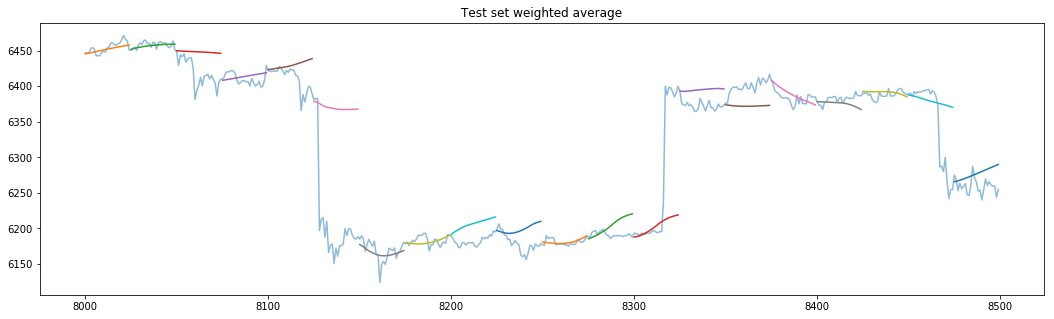

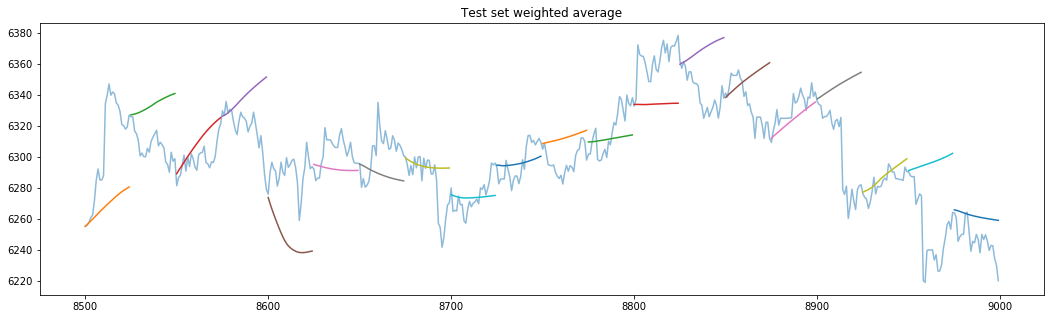

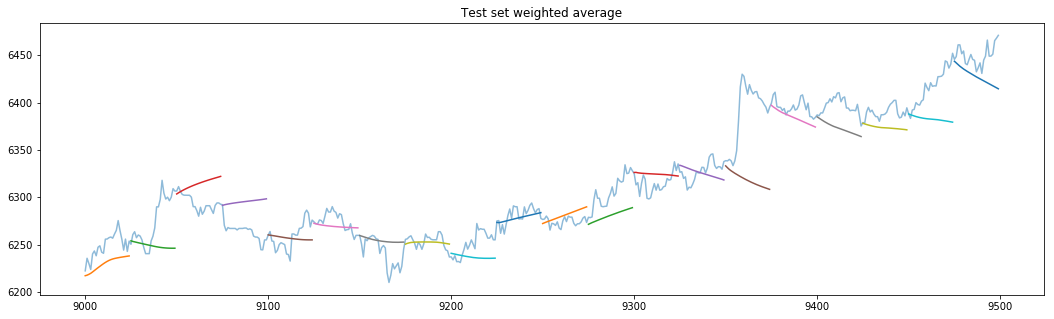

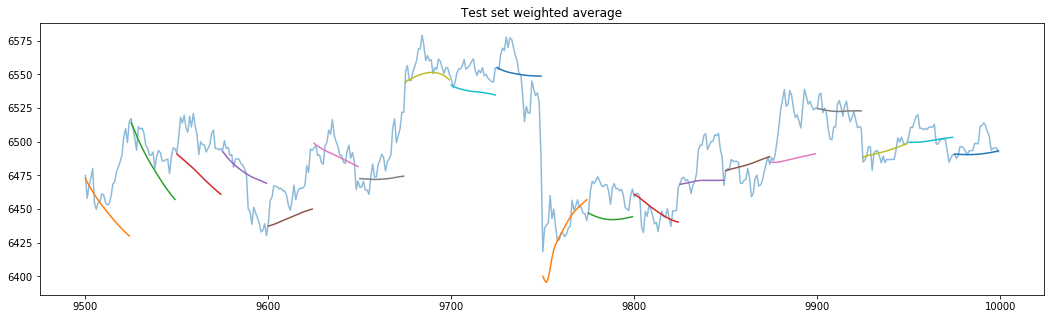

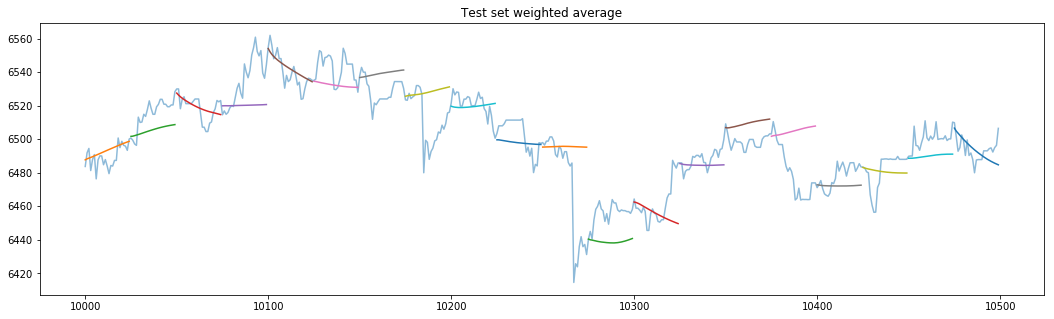

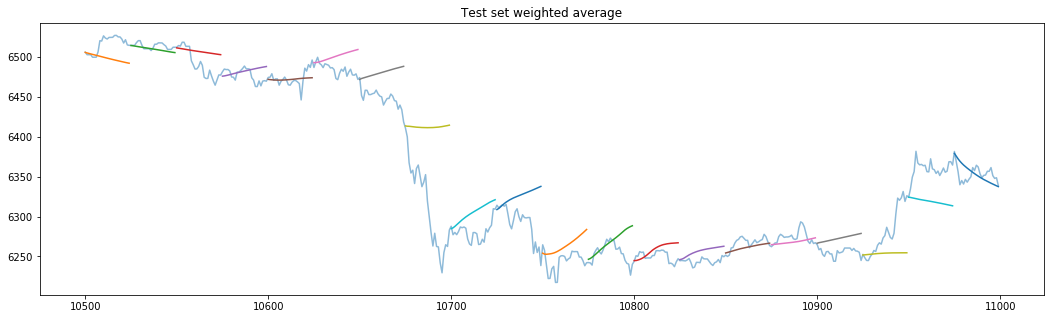

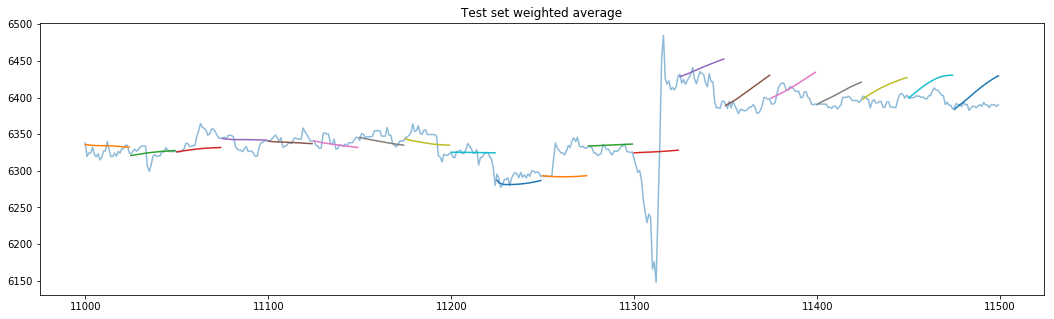

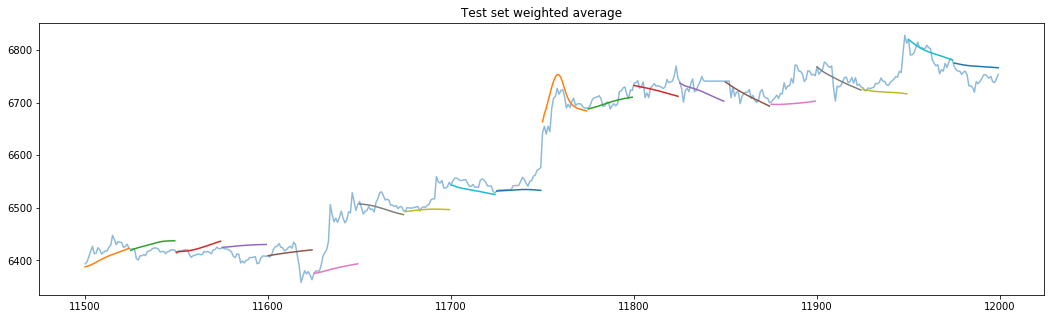

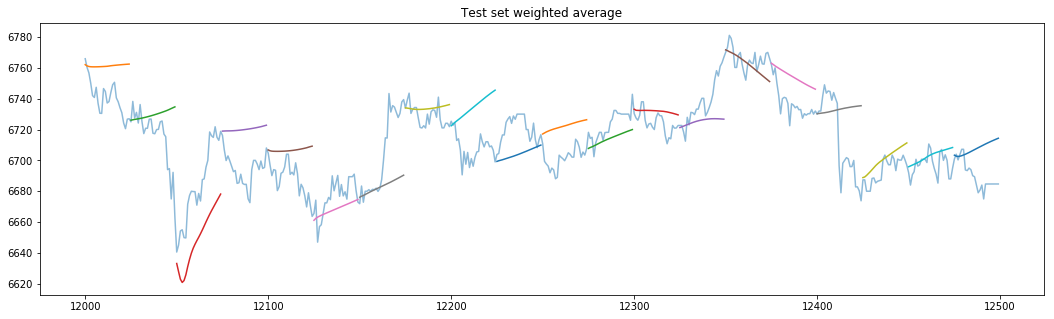

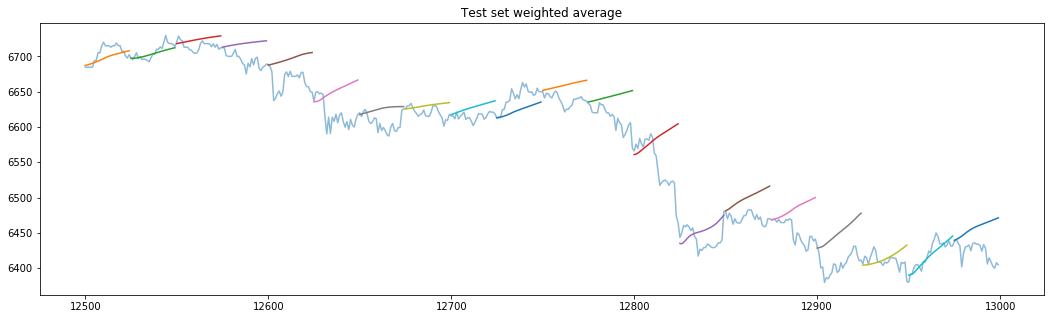

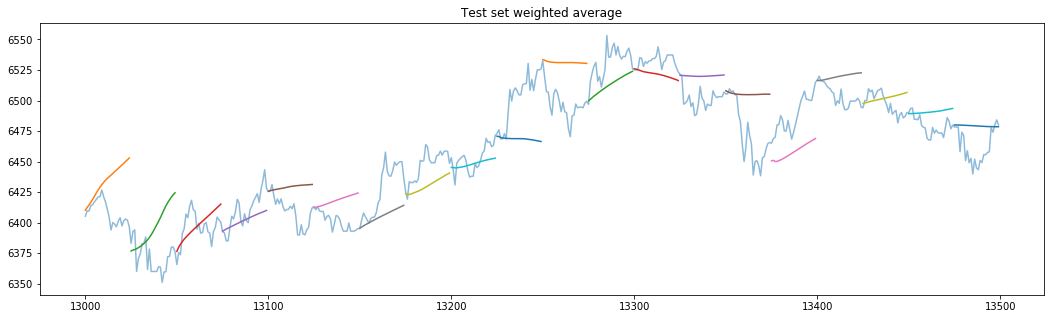

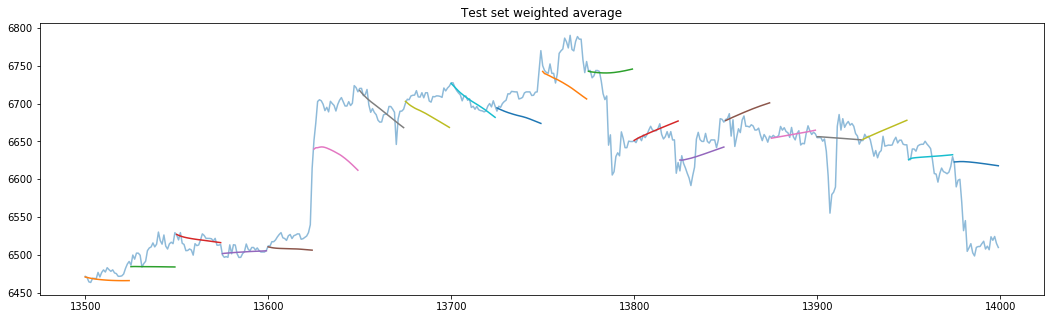

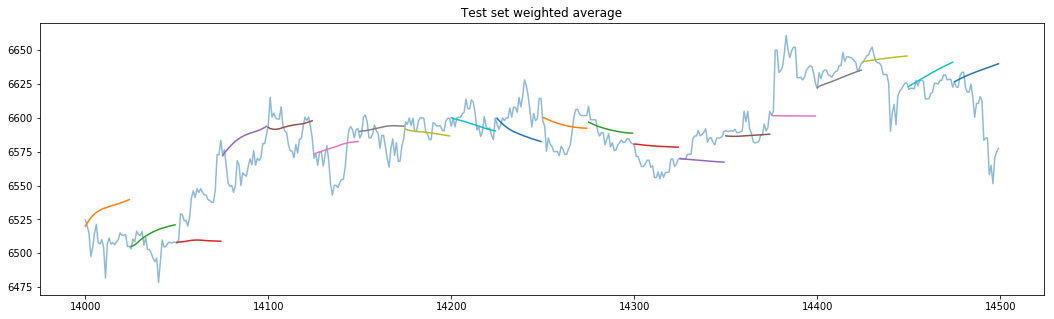

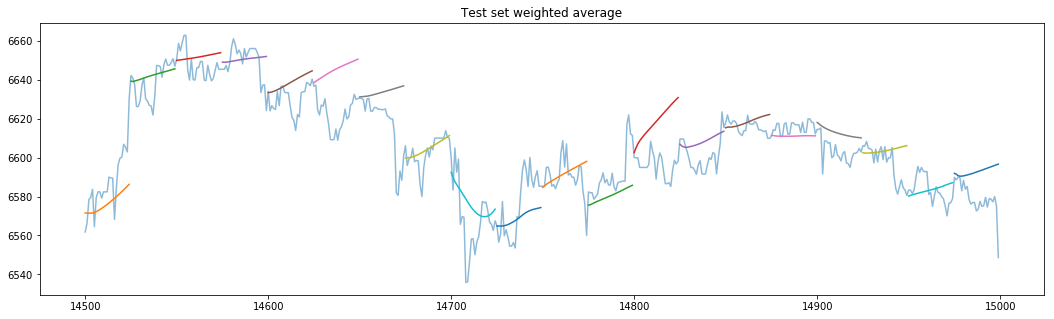

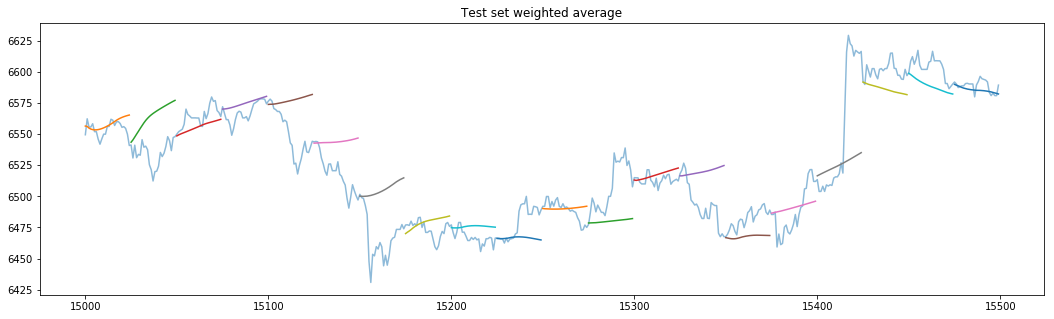

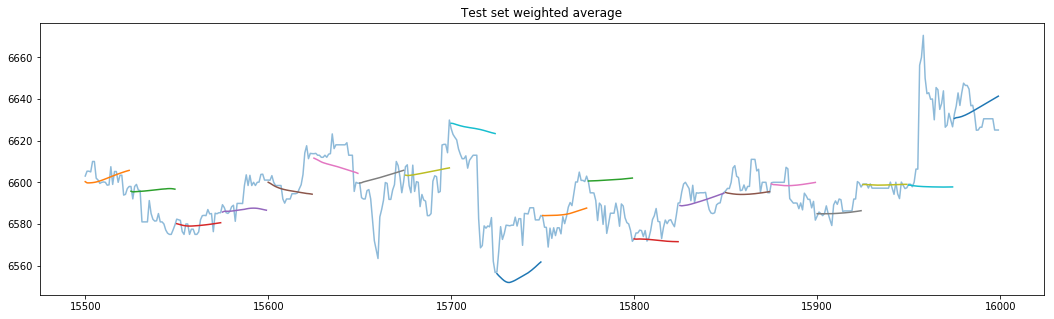

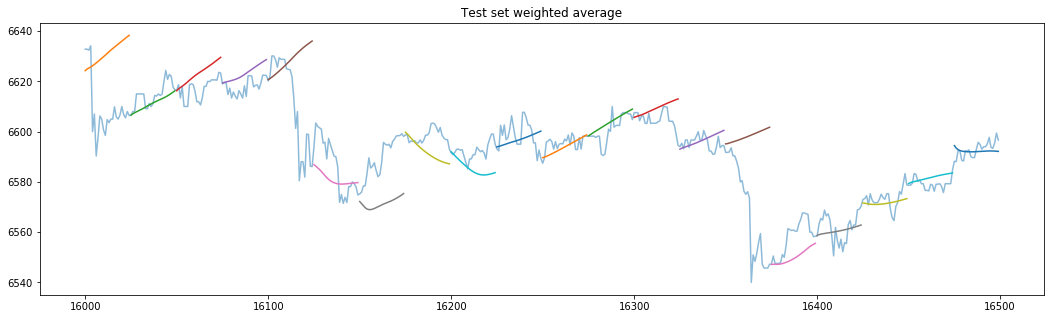

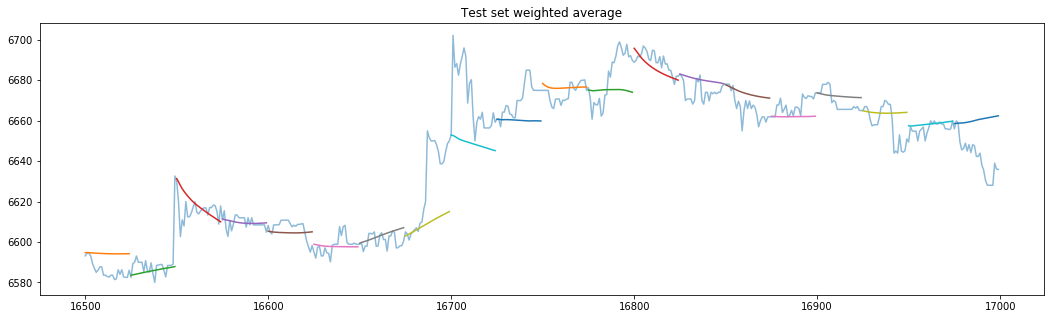

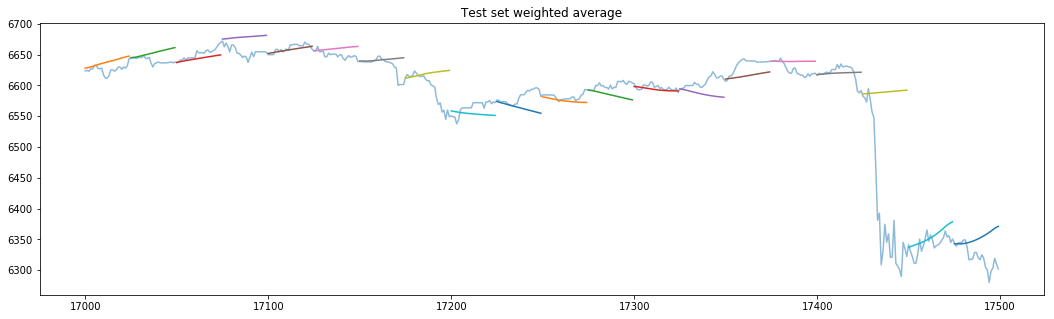

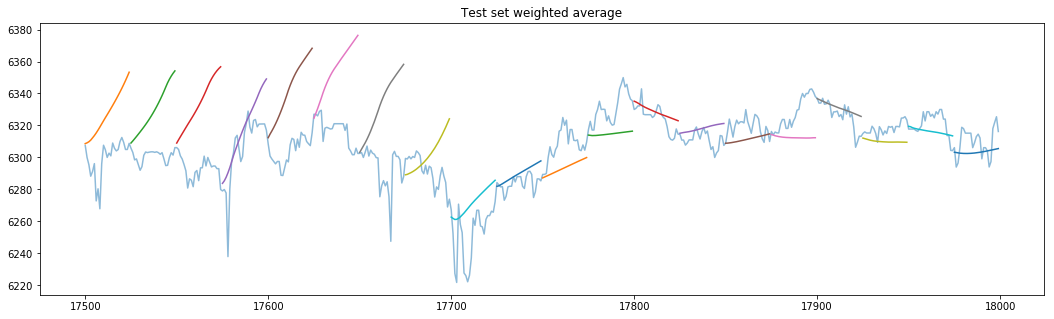

In [22]:
# Plot forecasts on real chart

import matplotlib.pyplot as plt

plot_length = 500
number_of_plots = test_close.shape[0] // plot_length

for i in range(number_of_plots):
    
    plt.figure(figsize=(18, 5))
    plt.title('Test set weighted average')
    start = i*plot_length
    end = (i+1)*plot_length
    plt.plot(range(start,end), test_close[start:end], alpha=0.5)
    for k in range(start, end, prediction_range):
        plt.plot(range(start,k+prediction_range), [None for j in range(k-start)] + [x for x in pred_close[k:k+prediction_range]])
    plt.show()